## Project Eclipse data on the Planetary Computer

### Using the STAC API

Project Eclipse data are distributed as a set of parquet files -- one per week. We can use the STAC API to search for files for a specific week.

In [1]:
import pystac_client

catalog = pystac_client.Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac"
)
search = catalog.search(collections=["eclipse"], datetime="2021-10-10")
items = search.get_all_items()

In [2]:
len(items)

1

In [84]:
import planetary_computer

item = planetary_computer.sign(items[0])
item

<Item id=eclipse-2021-10-10>

We'll load the parquet file with pandas.

In [9]:
import geopandas
import pandas as pd

asset = item.assets["data"]
df = pd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df

,City,DeviceId,LocationName,Latitude,Longitude,ReadingDateTimeUTC,PM25,CalibratedPM25,Humidity,O3,NO2,RawCO,BatteryLevel,PercentBattery,CellSignal
0,Chicago,2002,State & Garfield (SB),41.804031,-87.631180,2021-10-10 00:00:27,9.061397,10.94,75.457764,28.734678,101.334366,0.053757,4.216094,98.184006,-80.0
1,Chicago,2002,State & Garfield (SB),41.804031,-87.631180,2021-10-10 00:05:37,13.271815,12.16,76.522827,43.264297,93.634483,0.031024,4.217031,98.184006,-79.0
2,Chicago,2002,State & Garfield (SB),41.804031,-87.631180,2021-10-10 00:10:47,11.649896,11.40,76.893616,34.455231,98.901840,0.036157,4.216406,98.184006,-80.0
3,Chicago,2002,State & Garfield (SB),41.804031,-87.631180,2021-10-10 00:15:57,7.300192,8.56,76.832581,43.760769,94.716995,0.034428,4.218906,98.075966,-80.0
4,Chicago,2002,State & Garfield (SB),41.804031,-87.631180,2021-10-10 00:21:07,7.204994,13.27,77.096558,47.520630,98.961983,0.116734,4.215000,98.075966,-80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206874,Chicago,2191,Belmont & Western (WB),41.944355,-87.684441,2021-10-16 23:39:09,1.241057,7.01,45.266724,9.740115,80.221870,0.039386,4.176406,90.308594,-89.0
206875,Chicago,2191,Belmont & Western (WB),41.944355,-87.684441,2021-10-16 23:44:19,4.558146,9.48,45.564270,10.116728,79.707535,0.045806,4.193906,90.203125,-89.0
206876,Chicago,2191,Belmont & Western (WB),41.944355,-87.684441,2021-10-16 23:49:29,1.819272,7.54,45.904541,5.178057,80.906311,0.042392,4.192969,90.203125,-90.0
206877,Chicago,2191,Belmont & Western (WB),41.942932,-87.690689,2021-10-16 23:54:39,4.898626,9.94,46.276855,11.263342,80.043747,0.050152,4.192500,90.203125,-87.0


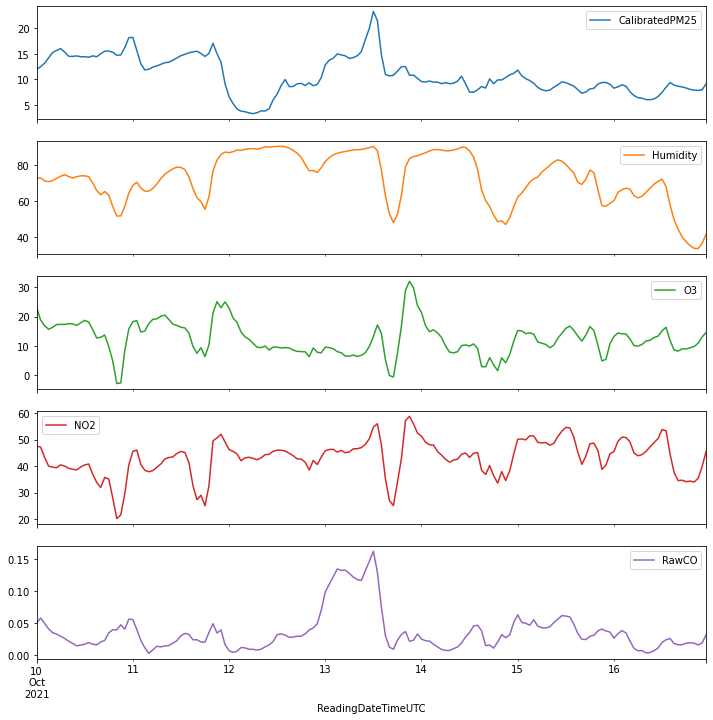

In [14]:
ts = df.resample("H", on="ReadingDateTimeUTC")[
    ["CalibratedPM25", "Humidity", "O3", "NO2", "RawCO"]
].mean()
ts.plot(subplots=True, sharex=True, figsize=(12, 12));

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

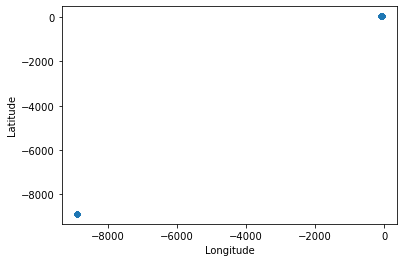

In [34]:
df.plot.scatter(x="Longitude", y="Latitude")

In [36]:
df.Latitude.sort_values()

198750   -8888.0
198689   -8888.0
198688   -8888.0
198687   -8888.0
198686   -8888.0
           ...  
182824       NaN
190435       NaN
191000       NaN
191023       NaN
191163       NaN
Name: Latitude, Length: 206879, dtype: float64

In [37]:
df.Longitude.sort_values()

23991    -8888.0
198654   -8888.0
198653   -8888.0
198652   -8888.0
198651   -8888.0
           ...  
182824       NaN
190435       NaN
191000       NaN
191023       NaN
191163       NaN
Name: Longitude, Length: 206879, dtype: float64

In [51]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="epsg:4326"
)
gdf = gdf[(gdf.Longitude > -8888) & (df.Latitude > -8888)]

gdf[["LocationName", "geometry"]].drop_duplicates(
    subset="LocationName"
).dropna().explore()

### Reading the full dataset

The STAC collection includes a link to the root of the parquet dataset with all of the data.

In [55]:
eclipse = catalog.get_collection("eclipse")
asset = planetary_computer.sign(eclipse.assets["data"])

In [60]:
import dask.dataframe as dd

ddf = dd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ddf

,City,DeviceId,LocationName,Latitude,Longitude,ReadingDateTimeUTC,PM25,CalibratedPM25,Humidity,O3,NO2,RawCO,BatteryLevel,PercentBattery,CellSignal
npartitions=25,,,,,,,,,,,,,,,
,object,int32,object,float64,float64,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [78]:
ts = ddf.set_index("ReadingDateTimeUTC")

In [81]:
data = ts[["O3", "NO2"]].resample("H").mean().compute()

<AxesSubplot:xlabel='ReadingDateTimeUTC'>

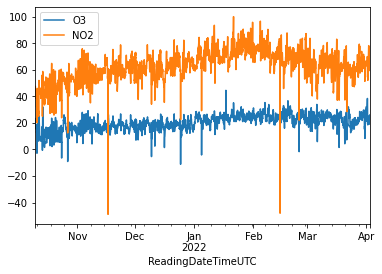

In [83]:
data.plot()